In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Research Supervisor

*The supervisor has a simple job: delegate research tasks to an appropriate number of sub-agents.*

Here is our overall research flow:

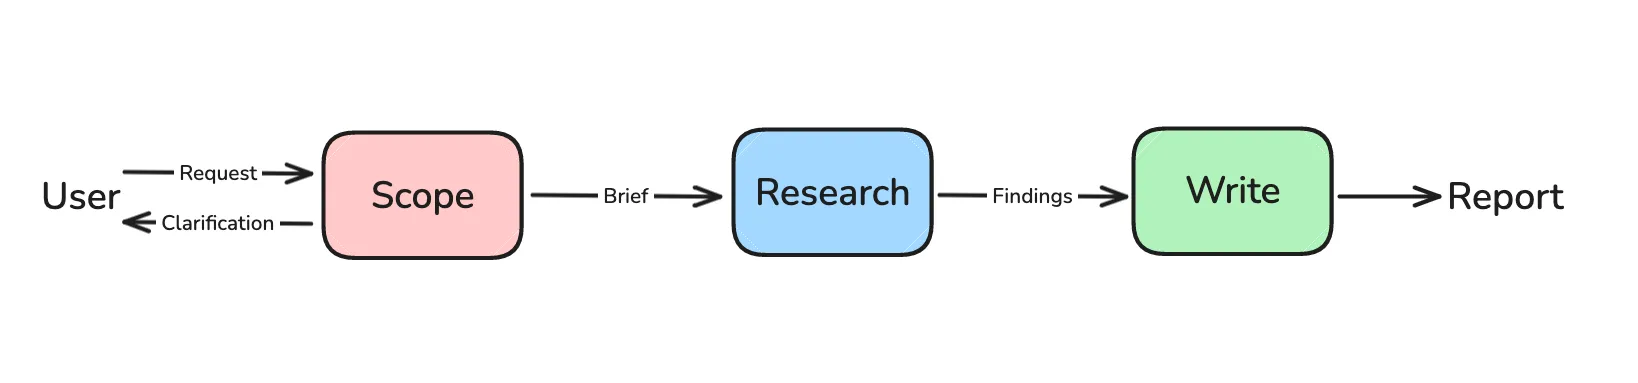

We previously built a research agent bound to either custom tools or MCP server. Now, what happens if the request is complex and has several sub-topics? Single agent response quality *can* suffer with multiple sub-topics (e.g., compare A to B to C) because a single context window needs to store and reason about tool feedback across all of the sub-topics. 

[Numerous failure modes](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), such as [context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), become prevalent as the context window accumulates tool calls across many different sub-topics. As discussed in [Anthropic's blog post](https://www.anthropic.com/engineering/built-multi-agent-research-system), multi-agent systems can split sub-topic to sub-agents with isolated context windows. We'll build a system where a supervisor determines if the research brief can be broken-down into independent sub-topics and delegates to sub-agents with isolated context windows. 

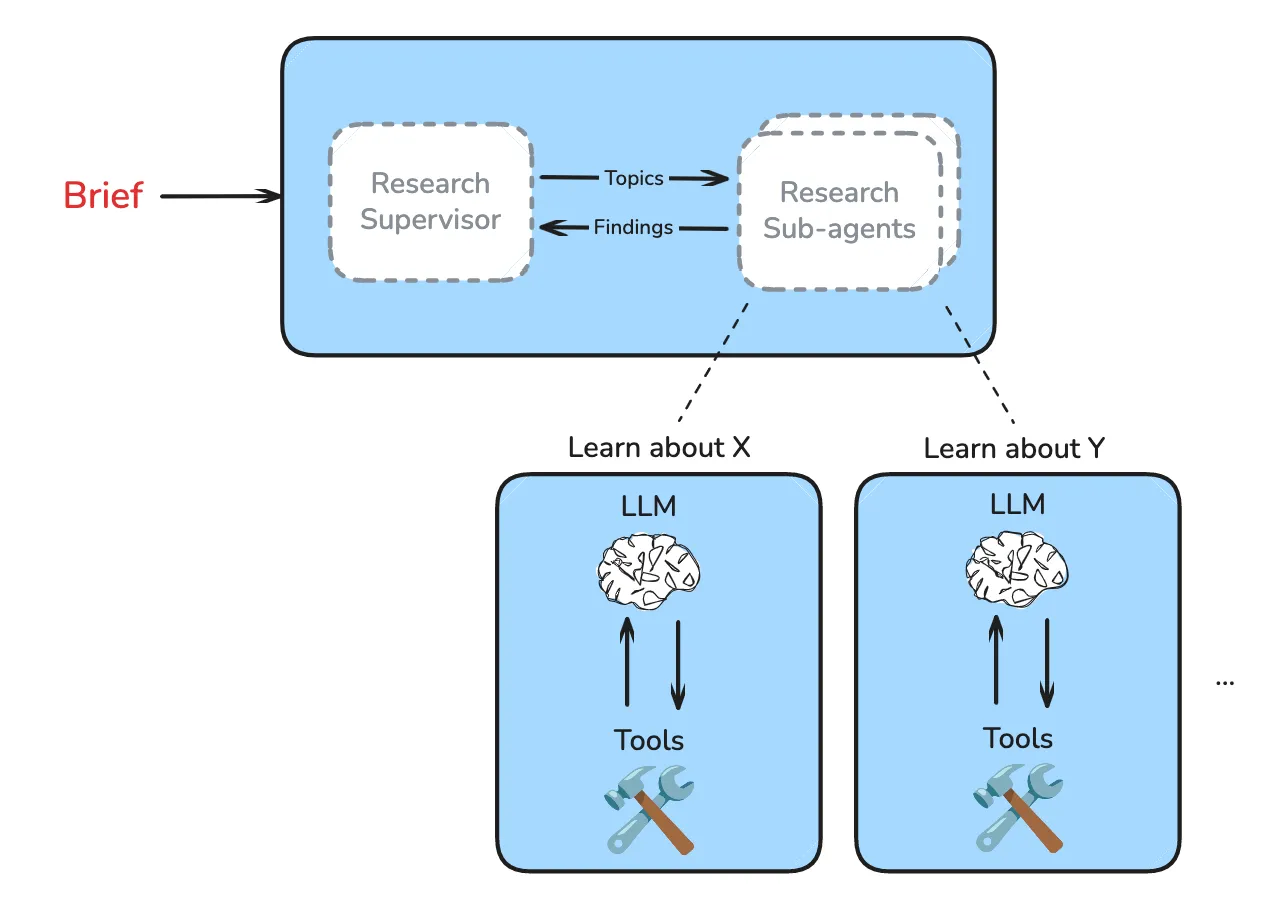

### Prompt

Now, let's design a prompt for the supervisor that follows the principles we've discussed, and include some insights from [the research literature](https://www.anthropic.com/engineering/built-multi-agent-research-system).

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the research. Are there multiple independent directions that can be explored simultaneously?
- **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still missing?

#### 2. Concrete Heuristics (For task delegation)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Bias towards single agent** - Use single agent for simplicity unless the user request has clear opportunity for parallelization. 
- **Stop when you can answer confidently** - Don't keep delegating research for perfection.
- **Limit tool calls** - Always stop after 3 tool calls to ConductResearch if you cannot find the right source(s).

#### 3. Show your thinking
Before you call ConductResearch tool call, use think_tool to plan your approach:
- Can the task be broken down into smaller sub-tasks?

After each ConductResearch tool call, use think_tool to analyze the results:
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

#### 4. Scaling rules
Simple fact-finding, lists, and rankings can use a single sub-agent.
- *Example*: List the top 10 coffee shops in San Francisco -> Use 1 sub-agent

Comparisons presented in the user request can use a sub-agent for each element of the comparison.
- *Example*: Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety -> Use 3 sub-agents.
- Delegate clear, distinct, non-overlapping subtopics

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

### State

The supervisor state manages the overall research coordination, while the researcher state handles individual research tasks.

In [3]:
%%writefile ../src/deep_research_from_scratch/state_multi_agent_supervisor.py

"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    
    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], operator.add] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Overwriting ../src/deep_research_from_scratch/state_multi_agent_supervisor.py


### Multi-agent 

Now, we'll define our agent. A multi-agent system is a system that consists of multiple agents that work together to complete a task. The main benefit is context isolated, as discussed in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/). 

In [4]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState, 
    ConductResearch, 
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it


# ===== CONFIGURATION =====

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model = init_chat_model(model="openai:gpt-4.1")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 6 # Calls to think_tool + ConductResearch

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

# ===== SUPERVISOR NODES =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Initialize variables for single return pattern
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # Default next step
    should_end = False
    
    # Check exit criteria first
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    
    else:
        # Execute ALL tool calls before deciding next step
        try:
            # Separate think_tool calls from ConductResearch calls
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # Handle think_tool calls (synchronous)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            # Handle ConductResearch calls (asynchronous)
            if conduct_research_calls:
                # Launch parallel research agents
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # Wait for all research to complete
                tool_results = await asyncio.gather(*coros)

                # Format research results as tool messages
                # Each sub-agent returns compressed research findings in result["compressed_research"]
                # We write this compressed research as the content of a ToolMessage, which allows
                # the supervisor to later retrieve these findings via get_notes_from_tool_calls()
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # Aggregate raw notes from all research
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
    
    # Single return point with appropriate state updates
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ===== GRAPH CONSTRUCTION =====

# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor.py


In [9]:
from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# Show the agent
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

NameError: name 'MermaidDrawMethod' is not defined

In [10]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The user has requested a ranking or list of the best coffee shops in San Francisco, focusing   │
│ exclusively on coffee quality. Appropriate sources include official coffee shop websites, reputable coffee      │
│ review organizations (e.g., Coffee Review, Specialty Coffee Association), and major user review sites for       │
│ customer feedback on coffee quality. The core research task is to identify which coffee shops are considered    │
│ the best for coffee quality and to compare them by this variable, using current information as of July 2025.    │
│ Since this is a specialized, but unified, fact-finding task without sub-category comparisons (like ambiance vs. │
│ coffee quality), a single research agent should be sufficient to gather and synthesize the most respected       │
│ lists, rankings, and reviews specifically evaluating coffee quality from the prioritized sources mentioned."    │
│ }                                                                                                               │
│    ID: call_11SPgDB9f0QnLmcBnWK9jocx                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The user has requested a ranking or list of the best coffee shops in San Francisco,        │
│ focusing exclusively on coffee quality. Appropriate sources include official coffee shop websites, reputable    │
│ coffee review organizations (e.g., Coffee Review, Specialty Coffee Association), and major user review sites    │
│ for customer feedback on coffee quality. The core research task is to identify which coffee shops are           │
│ considered the best for coffee quality and to compare them by this variable, using current information as of    │
│ July 2025. Since this is a specialized, but unified, fact-finding task without sub-category comparisons (like   │
│ ambiance vs. coffee quality), a single research agent should be sufficient to gather and synthesize the most    │
│ respected lists, rankings, and reviews specifically evaluating coffee quality from the prioritized sources      │
│ mentioned.                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Identify and evaluate the top coffee shops in San Francisco based specifically on coffee   │
│ quality, using the latest available data as of July 2025. Prioritize authoritative sources such as official     │
│ coffee shop websites for details of their coffee offerings, awards or certifications from organizations like    │
│ Coffee Review or the Specialty Coffee Association, and recent customer feedback about coffee quality from major │
│ review aggregators such as Google Reviews and Yelp. Compile a well-supported list or ranking that emphasizes    │
│ comparative coffee quality, noting specific criteria or ratings where available."                               │
│ }                                                                                                               │
│    ID: call_6QlN6lUwmopRWp147WODkXKH                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│ - "top San Francisco coffee shops for coffee quality July 2025 recent rankings Specialty Coffee Association     │
│ Coffee Review awards"                                                                                           │
│ - "Coffee Movement San Francisco awards Specialty Coffee Association Coffee Review 2025 ratings"                │
│ - "Saint Frank San Francisco coffee awards Specialty Coffee Association Coffee Review customer reviews 2025"    │
│ - "Sextant Coffee Roasters San Francisco 2025 awards ratings Coffee Review Specialty Coffee Association Google  │
│ Reviews"                                                                                                        │
│ - "Shoji Coffee San Francisco 2025 reviews coffee awards Specialty Coffee Association"                          │
│ - "Outset Coffee San Francisco 2025 coffee quality reviews Specialty Coffee Association Coffee Review"          │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ From the **Yelp** listing for "Top 10 Best Specialty Coffee in San Francisco, CA" last updated August 2025,     │
│ coffee shops including The Coffee Movement, Golden Goat Coffee, Sightglass Coffee were identified as top picks  │
│ [1].                                                                                                            │
│                                                                                                                 │
│ **Eater SF:**                                                                                                   │
│ The webpage showcases the absolute best coffee shops currently in San Francisco, highlighting the city's        │
│ pivotal role in the evolution of American coffee culture. San Francisco is notable as the birthplace of the     │
│ term "third wave coffee," the introduction of Yemeni coffee to the West Coast, the origin of Irish Coffee, and  │
│ the invention of vacuum-sealed coffee. The article features 16 top coffee shops, including newcomers like Caffe │
│ Trieste, the Coffee Movement at Side A, and Cafe Shoji, while others such as Coffee Movement on Balboa Street,  │
│ Poorboy Coffee, and Flywheel Coffee have been removed from the list.                                            │
│ Key coffee spots mentioned include:                                                                             │
│ - Saint Frank Coffee                                                                                            │
│ - Outset Coffee (known for fruit coffee innovations)                                                            │
│ - Scullery                                                                                                      │
│ - Sextant Coffee Roasters (noted for affordable, high-end beans and pastries)                                   │
│ - Telescope Coffee (offering unique coffee and non-coffee drinks)                                               │
│ - Abanico Coffee Roasters (bringing specialty coffee with Latin American influences)                            │
│ - Other featured shops include SPRO in multiple locations, Grand Coffee with its new spacious venue, Hey        │
│ Neighbor Cafe in Bayview with specialty toast and cat co-owner, Excelsior Coffee known for chai and             │
│ representation in the coffee scene, Andytown Coffee Roasters with its loyal westside following, Hi NRG pop-up   │
│ specializing in Hong Kong-inspired lattes, Paper Son bl

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research has provided a comprehensive synthesis of the latest (as of July/August 2025)     │
│ rankings, reviews, and certifications for coffee shops in San Francisco, with coffee quality as the core        │
│ criterion. Primary sources include Yelp, Eater SF, the Specialty Coffee Association, TripAdvisor, and           │
│ individual coffee shop websites. I have concrete ratings, customer testimonials about coffee quality, notes on  │
│ specialty certifications, and context from prominent review aggregators. Notably, The Coffee Movement, Saint    │
│ Frank, Sextant Coffee Roasters, Outset Coffee, and Shoji repeatedly appear as top-tier, with specific           │
│ recognition of coffee quality.\n\nMissing elements (small): Explicit scores or awards/certifications for each   │
│ shop from the specialty organizations could be more granular, but in practice such awards tend to be general or │
│ product-focused, not shop-wide. Still, most top candidate shops are repeatedly cited by credible bodies and     │
│ customer consensus.\n\nI have sufficient, up-to-date, well-supported evidence for a high-quality answer         │
│ focusing on comparative coffee quality. I am ready to mark the research complete."                              │
│ }                                                                                                               │
│    ID: call_uYAUfvH6mE7WBUx5lNbDM5mO                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research has provided a comprehensive synthesis of the latest (as of July/August 2025) │
│ rankings, reviews, and certifications for coffee shops in San Francisco, with coffee quality as the core        │
│ criterion. Primary sources include Yelp, Eater SF, the Specialty Coffee Association, TripAdvisor, and           │
│ individual coffee shop websites. I have concrete ratings, customer testimonials about coffee quality, notes on  │
│ specialty certifications, and context from prominent review aggregators. Notably, The Coffee Movement, Saint    │
│ Frank, Sextant Coffee Roasters, Outset Coffee, and Shoji repeatedly appear as top-tier, with specific           │
│ recognition of coffee quality.                                                                                  │
│                                                                                                                 │
│ Missing elements (small): Explicit scores or awards/certifications for each shop from the specialty             │
│ organizations could be more granular, but in practice such awards tend to be general or product-focused, not    │
│ shop-wide. Still, most top candidate shops are repeatedly cited by credible bodies and customer consensus.      │
│                                                                                                                 │
│ I have sufficient, up-to-date, well-supported evidence for a high-quality answer focusing on comparative coffee │
│ quality. I am ready to mark the research complete.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│    ID: call_wv53NnNoYmRuCVEbvslmgKXe                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

We can look at the trace [here](https://smith.langchain.com/public/99eaaecd-fd9a-4ead-8eed-abdfe4ab9288/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent_supervisor` in the dropdown menu:

```
"research_agent_supervisor": "./src/deep_research_from_scratch/multi_agent_supervisor.py:supervisor_agent",
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

The clear benefit of multi-agent is context isolation when there are clearly separable sub-topics. As we discuss [in our blog](https://blog.langchain.com/open-deep-research/): 

> Our experiments showed that single agent response quality suffers if the request has multiple sub-topics (e.g., compare A to B to C). The intuition here is straightforward: a single context window needs to store and reason about tool feedback across all of the sub-topics. This tool feedback is often token heavy. Numerous failure modes, such as context clash, become prevalent as the context window accumulates tool calls across many different sub-topics.

But, we want to be careful not to spawn sub-agents in cases where it is not required:

> The supervisor can handle both cases by selectively spawning sub-agents to tune the level of research depth needed for a request. The supervisor is prompted with heuristics to reason about when research should be parallelized, and when a single thread of research is sufficient. Our deep research agent has the flexibility to choose whether to parallelize research or not.

Let's set up a few tests to make sure that we are parallelizing when it makes sense.

In [7]:
# Example messages with think_tool calls and tool messages for evaluation
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [23]:
import os
from langsmith import Client

# Initialize client 
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

Now we can run evals.

In [9]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

View the evaluation results for experiment: 'Supervisor Parallelism-b4e2c6e6' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/87d6f859-3fc2-4727-a213-4106ef8851ae/compare?selectedSessions=a7113523-bfbb-472b-bf37-810ae9f22e09




0it [00:00, ?it/s]

<AsyncExperimentResults Supervisor Parallelism-b4e2c6e6>

In the first example, we asked the agent to compare and contrast products.

This sort of problem is great for parallel research, and we expect the agent to deep dive into each lab in parallel before synthesizing findings when writing the report.

The second example asks the agent for the top restaurants in Chelsea, Manhattan. 

The agent needs to conduct a single thread of research here and reflect on websites that presumably list out highly rated restaurants. 

There's not an obvious opportunity for parallelism for this ranking task.